In [1]:
import anndata
import copy
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import ot
import pandas as pd
import pickle
import scanpy as sc
import scipy.stats
import seaborn as sb
import warnings
import anndata


import lineageot.inference
import lineageot.simulation
import lineageot.evaluation

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

from ott.geometry.geometry import Geometry
from jax import numpy as jnp

from moscot import FusedGW, Regularized, GW

from typing import *
from collections import namedtuple, defaultdict
import traceback
from time import perf_counter

In [3]:
data = namedtuple("data", "edist ldist rna_dist a b")
bnt = namedtuple("bnt", "tmat early_cost late_cost norm_diff converged time")

In [4]:
start_time = datetime.datetime.now()

In [5]:
data_path = "data/"
save_dir = "plots/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)  

In [6]:
#with open(data_path + 'pickled_filtered_anndata.p', 'rb') as file:
#    adata = pickle.load(file)
adata = anndata.read("filtered.h5ad")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage'
    var: 'Unnamed: 0', 'id', 'gene_short_name'

In [7]:
with open(data_path + "packer_pickle_lineage_tree.p", 'rb') as file:
    full_reference_tree = pickle.load(file)

### Normalization and preprocessing

In [8]:
# Removing partially lineage-labeled cells

adata = adata[adata.obs['lineage'].to_numpy() == adata.obs['random_precise_lineage'].to_numpy()].copy()
adata

AnnData object with n_obs × n_vars = 5123 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage'
    var: 'Unnamed: 0', 'id', 'gene_short_name'

#### Filtering cells + genes

In [9]:
adata.obs['n_counts'] = np.array(adata.X.sum(1)).squeeze()
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [10]:
%%time
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
adata

CPU times: user 20.1 s, sys: 45.5 s, total: 1min 5s
Wall time: 21.1 s


AnnData object with n_obs × n_vars = 5123 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'n_counts', 'log_counts', 'n_genes'
    var: 'Unnamed: 0', 'id', 'gene_short_name'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [11]:

adata.obs.index = adata.obs['cell']

adata = adata[adata.obs.index.sort_values()].copy()
# for some reason on linux we need to redo this
# possibly due to version change of anndata (or dependencies)
# it seems that the previous indexing changed the index
adata.obs.index = adata.obs['cell']

In [12]:
print("AnnData", anndata.__version__)
# issue above observed for AnnData 0.7.4

AnnData 0.7.6


### Embryo time selection

In [13]:
def assign_time_to_bin(bin_string):
    if bin_string == '< 100':
        return 75
    elif bin_string == '> 650':
        # arbitrary choice here
        return 700
    else:
        # end of time range
        return (0*int(bin_string[0:3]) + 1*int(bin_string[-3:]))
    return

In [14]:
# If you would like to save time by only running the evaluation
# on a subset of the cells, change num_subbatches to an integer larger than 1.

# randomly splitting each batch into subbatches 
# so that there are fewer cells and the evaluation runs faster
num_subbatches = 1
adata.obs['assigned_batch_time'] = adata.obs['embryo.time.bin'].map(lambda x: assign_time_to_bin(x)
                                                                   + np.random.randint(num_subbatches))

In [15]:
batches = adata.obs['assigned_batch_time'].unique()
batches = np.sort(batches)
print(batches)

[ 75 130 170 210 270 330 390 450 510 580 650 700]


In [16]:
def remove_unlisted_leaves(tree, kept_leaves, max_depth = 10):
    """
    Removes all leaves not listed in kept_leaves from the tree
    """
    
    for i in range(max_depth):
        all_leaves = lineageot.inference.get_leaves(tree, include_root = False)
        for leaf in all_leaves:
            if not leaf in kept_leaves:
                tree.remove_node(leaf)


def create_lineage_tree(adata, batch_time, reference_tree = full_reference_tree, obsm_key = 'X_pca'):
    selected_cells = adata[adata.obs['assigned_batch_time'] == batch_time]
    
    # no need to remove any nodes from the reference
    # (unobserved subtrees have no effect on the inference)
    new_tree = copy.deepcopy(full_reference_tree)
    
    bad_cell_list = []
    good_cell_list = []
    for cell in selected_cells.obs.index:
        cell_label = selected_cells.obs['random_precise_lineage'][cell]
        cell_index = adata.obs.index.get_loc(cell)
        
        parent = next(reference_tree.predecessors(cell_label))
        
        if batch_time <= new_tree.nodes[parent]['time']:
            warnings.warn('Nonpositive time to parent ('
                          + str(batch_time - new_tree.nodes[parent]['time'])
                          + ') encountered in batch '
                          + str(batch_time) 
                          + ' for cell ' + cell)
            bad_cell_list.append(cell)
            # filter this cell out
            continue
        else:
            good_cell_list.append(cell)
        
        new_tree.add_node(cell)
        new_tree.add_edge(parent, cell)
        
        new_tree.nodes[cell]['name'] = cell_label
        new_tree.nodes[cell]['time'] = batch_time
        new_tree.nodes[cell]['time_to_parent'] = batch_time - new_tree.nodes[parent]['time']
        new_tree.nodes[cell]['cell'] = lineageot.simulation.Cell(adata.obsm[obsm_key][cell_index, :], cell_label)
        
        assert(new_tree.nodes[cell]['time_to_parent'] >= 0)
        
        
    return new_tree, good_cell_list, bad_cell_list

In [17]:
%%time
trees_by_batch = [create_lineage_tree(adata, batch_time) for batch_time in batches]

<ipython-input-16-d2e8e9477f6f>:29: UserWarning: Nonpositive time to parent (-147.0) encountered in batch 75 for cell GTGCGGTGTATGGTTC-b01
  warnings.warn('Nonpositive time to parent ('
<ipython-input-16-d2e8e9477f6f>:29: UserWarning: Nonpositive time to parent (-52.0) encountered in batch 130 for cell TACGGATGTACCCAAT-b01
  warnings.warn('Nonpositive time to parent ('
<ipython-input-16-d2e8e9477f6f>:29: UserWarning: Nonpositive time to parent (-2.0) encountered in batch 170 for cell ACATCAGCAATCCAAC-r17
  warnings.warn('Nonpositive time to parent ('
<ipython-input-16-d2e8e9477f6f>:29: UserWarning: Nonpositive time to parent (-12.0) encountered in batch 170 for cell ATCTGCCAGGCATTGG-r17
  warnings.warn('Nonpositive time to parent ('
<ipython-input-16-d2e8e9477f6f>:29: UserWarning: Nonpositive time to parent (-20.0) encountered in batch 170 for cell CACTCCAAGCTGCCCA-r17
  warnings.warn('Nonpositive time to parent ('
<ipython-input-16-d2e8e9477f6f>:29: UserWarning: Nonpositive time to pa

<ipython-input-16-d2e8e9477f6f>:29: UserWarning: Nonpositive time to parent (-10.0) encountered in batch 270 for cell CACACAAAGGGAACGG-300.1.2
  warnings.warn('Nonpositive time to parent ('
<ipython-input-16-d2e8e9477f6f>:29: UserWarning: Nonpositive time to parent (-20.0) encountered in batch 270 for cell CCTAAAGAGGGCTCTC-400.2.1
  warnings.warn('Nonpositive time to parent ('


CPU times: user 1.41 s, sys: 74.8 ms, total: 1.48 s
Wall time: 1.45 s


In [18]:
# Counting the number of cells kept vs. filtered out
# for having a measurement time at or before their
# reference birth time
{batch_time : (len(t[1]), len(t[2])) for t,batch_time in zip(trees_by_batch, batches)}

{75: (0, 1),
 130: (14, 1),
 170: (151, 14),
 210: (755, 79),
 270: (1215, 2),
 330: (1534, 0),
 390: (678, 0),
 450: (463, 0),
 510: (206, 0),
 580: (2, 0),
 650: (5, 0),
 700: (3, 0)}

#### Making a ground truth coupling

In [19]:
def is_ancestor(late_cell, early_cell):
    if not late_cell[-1] in 'aplrdvx':
        warnings.warn('Ancestor checking not implemented for cell ' + late_cell + ' yet.')
        return
    else:
        return early_cell in late_cell

In [20]:
def ground_truth_coupling(early_tree, late_tree, early_cells, late_cells):
    n_early = len(early_cells)
    n_late = len(late_cells)
    coupling = np.zeros([n_early, n_late])
    for c_early, i in zip(early_cells, range(n_early)):
        for c_late, j in zip(late_cells, range(n_late)):
            if is_ancestor(late_tree.nodes[c_late]['name'],
                           early_tree.nodes[c_early]['name']):
                coupling[i, j] = 1
    
    # filter out zero rows and columns
    kept_early_cells = np.where(np.sum(coupling, 1) > 0)[0]
    kept_late_cells = np.where(np.sum(coupling, 0) > 0)[0]
    coupling = coupling[np.ix_(kept_early_cells, kept_late_cells)]
    
    
    # normalize to uniform marginal on late cells
    coupling = np.dot(coupling, np.diag(np.sum(coupling, 0)**(-1)))/len(kept_late_cells)
    
    return coupling, kept_early_cells, kept_late_cells
    

In [21]:
lot_data = namedtuple(
    "lot_data",
    "cost_matrix "
    "rna_cost "
    "early_time_rna_cost "
    "late_time_rna_cost "
    "early_marginal late_marginal "
    "ec_scale lc_scale "
    "eb_time lb_time "
    "e_cells l_cells "
    "ec_index lc_index "
    "ancestor_info true_coupling"
)

In [22]:
def prepare_lot_data(early_batch_time: int, late_batch_time: int, obsm_key: str = "X_pca"):
    early_batch_index = np.where(batches == early_batch_time)[0][0]
    late_batch_index = np.where(batches == late_batch_time)[0][0]
    early_cells = trees_by_batch[early_batch_index][1]
    late_cells = trees_by_batch[late_batch_index][1]
    
    true_coupling, kept_early_cells_index, kept_late_cells_index = ground_truth_coupling(
        trees_by_batch[early_batch_index][0],
        trees_by_batch[late_batch_index][0],
        trees_by_batch[early_batch_index][1],
        trees_by_batch[late_batch_index][1]
    )
    
    early_marginal = np.sum(true_coupling, 1)
    late_marginal = np.sum(true_coupling, 0)
    
    lineageOT_tree = copy.deepcopy(trees_by_batch[late_batch_index][0])
    remove_unlisted_leaves(
        lineageOT_tree,
        np.array(trees_by_batch[late_batch_index][1])[kept_late_cells_index], max_depth = 15
    )
    
    lineageot.inference.add_nodes_at_time(lineageOT_tree, early_batch_time)
    lineageot.inference.add_times_to_edges(lineageOT_tree)
    
    observed_nodes = trees_by_batch[late_batch_index][1]
    lineageot.inference.add_conditional_means_and_variances(lineageOT_tree, observed_nodes)
    ancestor_info = lineageot.inference.get_ancestor_data(lineageOT_tree, early_batch_time)
    
    lineage_rna_cost = ot.utils.dist(adata[early_cells].obsm[obsm_key],
                                 ancestor_info[0])@np.diag(ancestor_info[1]**(-1))
    rna_cost = ot.utils.dist(adata[early_cells].obsm[obsm_key],
                             adata[late_cells].obsm[obsm_key])

    late_time_rna_cost = ot.utils.dist(adata[late_cells].obsm[obsm_key],
                                       adata[late_cells].obsm['X_pca'])
    # note early_time_rna_cost here is different from in the simulation evaluation because we don't have
    # a single true ancestor for each late cell
    early_time_rna_cost = ot.utils.dist(adata[early_cells].obsm[obsm_key],
                                        adata[early_cells].obsm[obsm_key])



    lineage_rna_cost = lineage_rna_cost[kept_early_cells_index, :]
    rna_cost = rna_cost[np.ix_(kept_early_cells_index, kept_late_cells_index)]
    early_time_rna_cost = early_time_rna_cost[np.ix_(kept_early_cells_index, kept_early_cells_index)]
    late_time_rna_cost = late_time_rna_cost[np.ix_(kept_late_cells_index, kept_late_cells_index)]
    
    indep_coupling = np.outer(early_marginal, late_marginal)
    ind_early_cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(
        indep_coupling.T, true_coupling.T, early_time_rna_cost ).T, early_time_rna_cost
                                                )
    ind_late_cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(
        indep_coupling, true_coupling, late_time_rna_cost ).T, late_time_rna_cost
    )
    
    return lot_data(lineage_rna_cost, rna_cost, early_time_rna_cost, late_time_rna_cost,
                    early_marginal, late_marginal,
                    float(ind_early_cost), float(ind_late_cost),
                    early_batch_time, late_batch_time,
                    early_cells, late_cells,
                    kept_early_cells_index, kept_late_cells_index,
                    ancestor_info, true_coupling)

#### LineageOT coupling

In [23]:
def prepare_tree(ld: lot_data, *, late: bool):
    if late:
        batch_index = np.where(batches == ld.lb_time)[0][0]
        kept_cells_index = ld.lc_index  # kept_late_cells_index
    else:
        batch_index = np.where(batches == ld.eb_time)[0][0]
        kept_cells_index = ld.ec_index  # kept_early_cells_index
    tree = copy.deepcopy(trees_by_batch[batch_index][0])
    remove_unlisted_leaves(
        tree,
        np.array(trees_by_batch[batch_index][1])[kept_cells_index], max_depth = 15
    )
    n_added = lineageot.inference.add_nodes_at_time(tree, ld.eb_time)
    if late:
        assert n_added > 0, n_added
    else:
        assert n_added == 0, n_added
    lineageot.inference.add_times_to_edges(tree)
    
    return tree


def compute_tree_distances(tree):
    """
    Computes the matrix of pairwise distances between leaves of the tree
    """
    leaves = lineageot.inference.get_leaves(tree, include_root=False)
    num_leaves = len(leaves)
    distances = np.zeros([num_leaves, num_leaves])
    for i, leaf in enumerate(leaves):
        distance_dictionary, tmp = nx.multi_source_dijkstra(tree.to_undirected(), [leaf], weight = 'time')
        for j, target_leaf in enumerate(leaves):
            distances[i, j] = distance_dictionary[target_leaf]
    return distances


def cost(cmat: np.array, *, ld: lot_data, late: bool) -> float:
    cmat = np.asarray(cmat)
    if late:
        cost = lineageot.inference.OT_cost(
            lineageot.evaluation.expand_coupling(
                cmat, ld.true_coupling, ld.late_time_rna_cost), ld.late_time_rna_cost
        ) / ld.lc_scale
    else:
        cost = lineageot.inference.OT_cost(lineageot.evaluation.expand_coupling(
            cmat.T, ld.true_coupling.T, ld.early_time_rna_cost).T, ld.early_time_rna_cost
        ) / ld.ec_scale
        
    return cost


def prepare_moscot_data(ld: lot_data) -> data:
    etree = prepare_tree(ld, late=False)
    ltree = prepare_tree(ld, late=True)
    edist = compute_tree_distances(etree)
    ldist = compute_tree_distances(ltree)
    return data(edist, ldist, ld.rna_cost, ld.early_marginal, ld.late_marginal)


def create_geometry(cost_matrix: np.ndarray, scale: Optional[str] = 'max') -> Geometry:
    cost_matrix = jnp.array(cost_matrix)
    if scale is None:
        pass
    elif scale == 'max':
        cost_matrix /= cost_matrix.max()
        assert cost_matrix.max() == 1.0
    elif scale == 'mean':
        cost_matrix /= np.mean(cost_matrix)
    elif scale == 'median':
        cost_matrix /= np.median(cost_matrix)
    else:
        raise NotImplementedError(scale)
        
    assert (cost_matrix >= 0).all()
    return Geometry(cost_matrix=cost_matrix)


def benchmark_moscot(d: data, ld: lot_data, *, alpha: float, epsilon: Optional[float] = None,
                     scale: str = "max", **kwargs):
    scale_fn = {
        "max": jnp.max,
        "mean": jnp.mean,
        "median": jnp.median,
        None: None,
    }
    e = create_geometry(d.edist, scale=scale)
    l = create_geometry(d.ldist, scale=scale)
    joint = create_geometry(d.rna_dist, scale=scale)
    a = jnp.asarray(d.a)
    b = jnp.asarray(d.b)
    
    max_iterations = kwargs.pop("max_iterations", 20)
    rtol = kwargs.pop("rtol", 1e-6)
    atol = kwargs.pop("atol", 1e-6)
    
    start = perf_counter()
    if alpha == 0:
        u = Regularized(epsilon=epsilon)
        u.fit(joint, a=a, b=b)
        tmat = np.asarray(u.matrix)
        conv = [u.converged]
    elif alpha == 1:
        gw = GW(epsilon=epsilon)
        gw.fit(e, l, a=a, b=b)
        tmat = np.asarray(gw.matrix)
        conv = gw.converged_sinkhorn
    else:
        fgw = FusedGW(alpha=alpha, epsilon=epsilon, **kwargs)
        print("here", alpha, epsilon, scale)
        fgw.fit(e, l, joint, linesearch=False, verbose=True,
                a=a, b=b,
                scale_fn=scale_fn[scale],
                max_iterations=max_iterations, rtol=rtol, atol=atol)
        tmat = np.asarray(fgw.matrix)
        conv = fgw.converged_sinkhorn
        
    time = perf_counter() - start
    print(f"Time: {time}")
    
    if not np.all(np.isfinite(tmat)):
        raise AssertionError("Convergence issue - not all values are finite.")
    
    
    early_cost = cost(tmat, ld=ld, late=False)
    late_cost = cost(tmat, ld=ld, late=True)
    norm_diff = np.linalg.norm(tmat - ld.true_coupling)
    print(early_cost, late_cost)
        
    return bnt(tmat, early_cost, late_cost, norm_diff, conv, time)




def gridsearch(d: data, ld: lot_data, *, alphas: Sequence[float], epsilons: Sequence[float], rescale: bool = True, **kwargs) -> Dict[float, Dict[float, bnt]]:
    res = defaultdict(defaultdict)
        
    for alpha in alphas:
        for epsilon in epsilons:
            try:
                print(f"alpha={alpha}, epsilon={epsilon}")
                res[alpha][epsilon] = benchmark_moscot(d, ld, alpha=alpha, epsilon=epsilon, rescale=rescale, **kwargs)
            except Exception as e:
                print(traceback.format_exc())
                res[alpha][epsilon] = None
    
    return {a: {e: v for e, v in vs.items()} for a, vs in res.items()}


def gridsearch_lineageOT(ld: lot_data, *, epsilons: Sequence[float], **kwargs) -> Dict[float, Dict[float, bnt]]:
    res = defaultdict(defaultdict)
    for alpha in [None]:
        for e in epsilons:
            if e is None:
                res[alpha][e] = None
                continue
            try:
                print(f"alpha={alpha}, epsilon={e}")
                f = ot.sinkhorn if e >= 0.1 else ot.bregman.sinkhorn_epsilon_scaling
                # problem's with high eps for some time points - tmat was all 0s
                f = ot.bregman.sinkhorn_epsilon_scaling
                
                start = perf_counter()
                tmat = f(ld.early_marginal, ld.late_marginal, ld.cost_matrix, e*np.mean(ld.ancestor_info[1]**(-1)))
                time = perf_counter() - start
                if not np.all(np.isfinite(tmat)):
                    raise AssertionError("Convergence issue - not all values are finite.")
                
                early_cost = cost(tmat, ld=ld, late=False)
                late_cost = cost(tmat, ld=ld, late=True)
                norm_diff = np.linalg.norm(tmat - ld.true_coupling)
                print(early_cost, late_cost)
                tmp = bnt(tmat, early_cost, late_cost, norm_diff, [None], time)
                
                res[alpha][e] = tmp
            except Exception:
                print(traceback.format_exc())
                res[alpha][e] = None
    
    return {a: {e: v for e, v in vs.items()} for a, vs in res.items()}

In [24]:
def calculate_errors(ld: lot_data, couplings):
    ancestor_errors = {}
    descendant_errors = {}
    for key in couplings:
        ancestor_errors[key] = [ot.emd2(couplings[key][:, i]/np.sum(couplings[key][:, i]),
                                        couplings['true'][:, i]/np.sum(couplings['true'][:, i]),
                                        ld.early_time_rna_cost)
                                for i in range(couplings['true'].shape[1])]
        descendant_errors[key] = [ot.emd2(couplings[key][i, :]/np.sum(couplings[key][i, :]),
                                          couplings['true'][i, :]/np.sum(couplings['true'][i, :]),
                                          ld.late_time_rna_cost)
                                for i in range(couplings['true'].shape[0])]
        
    return ancestor_errors, descendant_errors


def plot_vs_errors(ancestor_errors, descendant_errors):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100, constrained_layout=True)
    for ax, descendant in zip(axes, [False, True]):
        data = descendant_errors if descendant else ancestor_errors
        modifier = "descendant" if descendant else "ancestor"
        xmax = max(np.max(data['moscot']), np.max(data['lineageOT'])) + 1

        ax.scatter(data['lineageOT'], data['moscot'], alpha=0.2, lw=0)
        ax.plot([0, xmax], [0, xmax], color='orange', alpha=0.8, zorder=-1)

        ax.set_title(modifier + " error")
        ax.set_xlabel(f"LineageOT")
        ax.set_ylabel(f"moscot")
        
        
def plot_umap(adata, ld: lot_data, ancestor_errors, descendant_errors, add_time: bool = True, keys=None, **kwargs):
    from matplotlib import rc_context
    
    if keys is None:
        keys = []
    early_cells_to_plot = [ld.e_cells[i] for i in ld.ec_index]
    late_cells_to_plot = [ld.l_cells[i] for i in ld.lc_index]
    cells_to_plot = early_cells_to_plot + late_cells_to_plot
    
    print("Plotting:", len(cells_to_plot), "cells")
    
    print("Computing embedding")
    adata_to_plot = adata[cells_to_plot].copy()
    sc.pp.neighbors(adata_to_plot)
    sc.tl.umap(adata_to_plot)
    
    for etype, cont, cells in zip(["ancestor", "descendant"],
                                  [ancestor_errors, descendant_errors],
                                  [late_cells_to_plot, early_cells_to_plot]):
        moscot_err = pd.Series(cont['moscot'], index=cells)
        lot_err = pd.Series(cont['lineageOT'], index=cells)
        diff = lot_err - moscot_err
        
        adata_to_plot.obs[f'LineageOT {etype} error'] = lot_err
        adata_to_plot.obs[f'moscot {etype} error'] = moscot_err
        adata_to_plot.obs[f'{etype} difference'] = diff
        
        # normed_diff = ((diff - diff.min()) / (diff.max() - diff.min()) - 0.5) * 2
        # normed_diff = 0.5 + diff / (2 * np.abs(diff).min())
        # adata_to_plot.obs[f'{etype} difference normalized'] = normed_diff

    with rc_context({"figure.dpi": 180}):
        _ = sc.pl.umap(adata_to_plot,
                   color=(['assigned_batch_time'] if add_time else []) + keys +
                       [f'{etype} difference' for etype in ['ancestor', 'descendant']],
                   cmap='seismic_r', title=(['time (minutes)'] if add_time else []) + keys +
                       ['ancestor error (LineageOT - moscot)', 'descendant error (LineageOT - moscot)'],
                       vmin=-diff.min(), vmax=diff.min(),
                   frameon=True, alpha=0.8, size=50, return_fig=False, **kwargs)

In [25]:
def plot(adata, early_tp: int, late_tp: int, *, moscot_key=None, lot_key=None):
    def find_min(haystack):
        minn, key = np.inf, None
        for alpha, vs in haystack.items():
            for epsilon, d in vs.items():
                if d is None:
                    continue
                val = np.mean([d.early_cost])#, d.late_cost])
                if val < minn:
                    minn = val
                    key = (alpha, epsilon)
        return key
    
    print("Early tp:", early_tp, "late tp:", late_tp)
    
    if (early_tp, late_tp) in cache:
        ld = cache[early_tp, late_tp]['ld']
        data = cache[early_tp, late_tp]['moscot']
        lot_data = cache[early_tp, late_tp]['lineageOT']
    else:
        print("Loading data")
        ld = prepare_lot_data(early_tp, late_tp)
        with open(f"c_elegans_{early_tp}_{late_tp}.pickle", "rb") as fin:
            data = pickle.load(fin)

        with open(f"c_elegans_lot_{early_tp}_{late_tp}.pickle", "rb") as fin:
            lot_data = pickle.load(fin)
        cache[early_tp, late_tp] = {}
        cache[early_tp, late_tp]['ld'] = ld
        cache[early_tp, late_tp]['moscot'] = data
        cache[early_tp, late_tp]['lineageOT'] = lot_data
        
    if moscot_key is None:
        moscot_key = find_min(data)
    print("Moscot key:", moscot_key)
    if lot_key is None:
        lot_key = find_min(lot_data)
    print("Lot key:", lot_key)
        
    mdata = data[moscot_key[0]][moscot_key[1]]
    ldata = lot_data[lot_key[0]][lot_key[1]]
    print("Moscot costs (early/late):", mdata.early_cost, mdata.late_cost)
    print("LineageOT costs (early/late):", ldata.early_cost, ldata.late_cost)
    
    couplings = {}
    couplings['moscot'] = mdata.tmat
    couplings['lineageOT'] = ldata.tmat
    couplings['true'] = ld.true_coupling
        
    ancestor_errors, descendant_errors = calculate_errors(ld, couplings)
    plot_vs_errors(ancestor_errors, descendant_errors)
    plot_umap(adata, ld, ancestor_errors, descendant_errors, add_time=True)

In [26]:
cache = {}  # in or

Early tp: 170 late tp: 210
Loading data
Moscot key: (1.0, 0.005)
Lot key: (None, 1)
Moscot costs (early/late): 0.0959905871952502 0.12015127368220828
LineageOT costs (early/late): 0.4832776585970506 0.49723526799369044
Plotting: 682 cells
Computing embedding


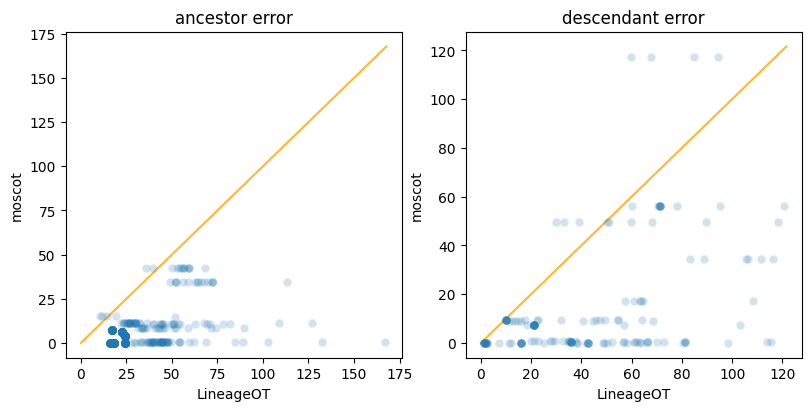

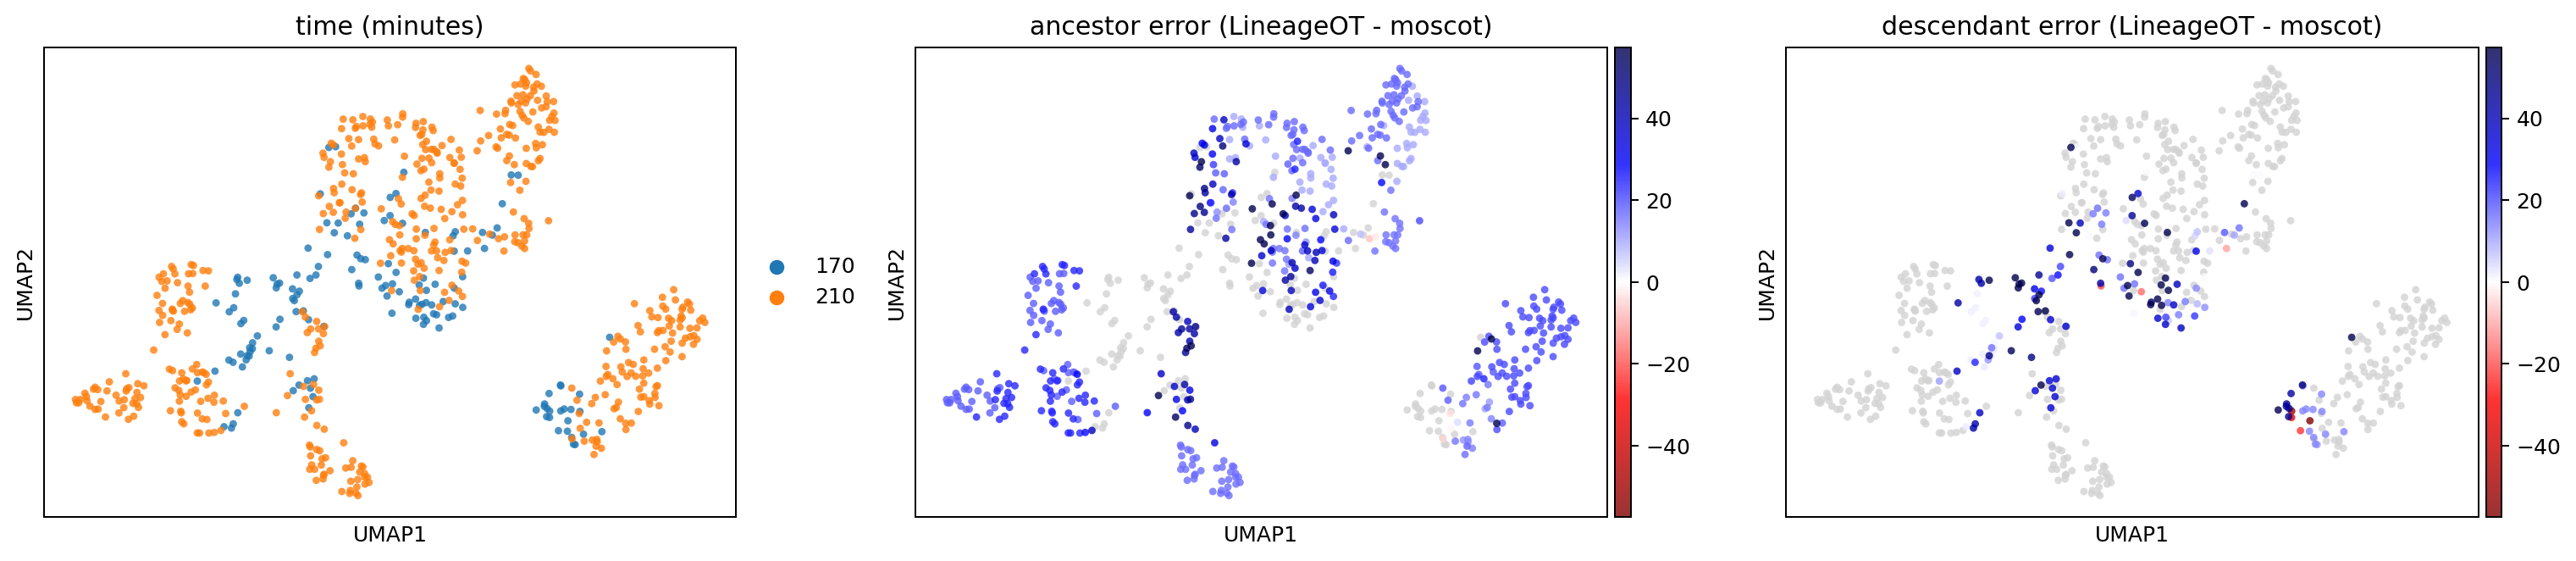

Early tp: 390 late tp: 450
Loading data
Moscot key: (1.0, 0.0001)
Lot key: (None, 1)
Moscot costs (early/late): 0.034162100593061316 0.025262238296718365
LineageOT costs (early/late): 0.32335517008093984 0.254705424632446
Plotting: 954 cells
Computing embedding


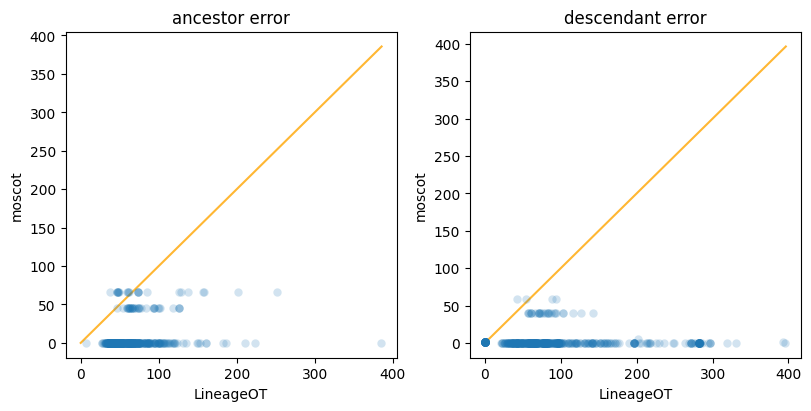

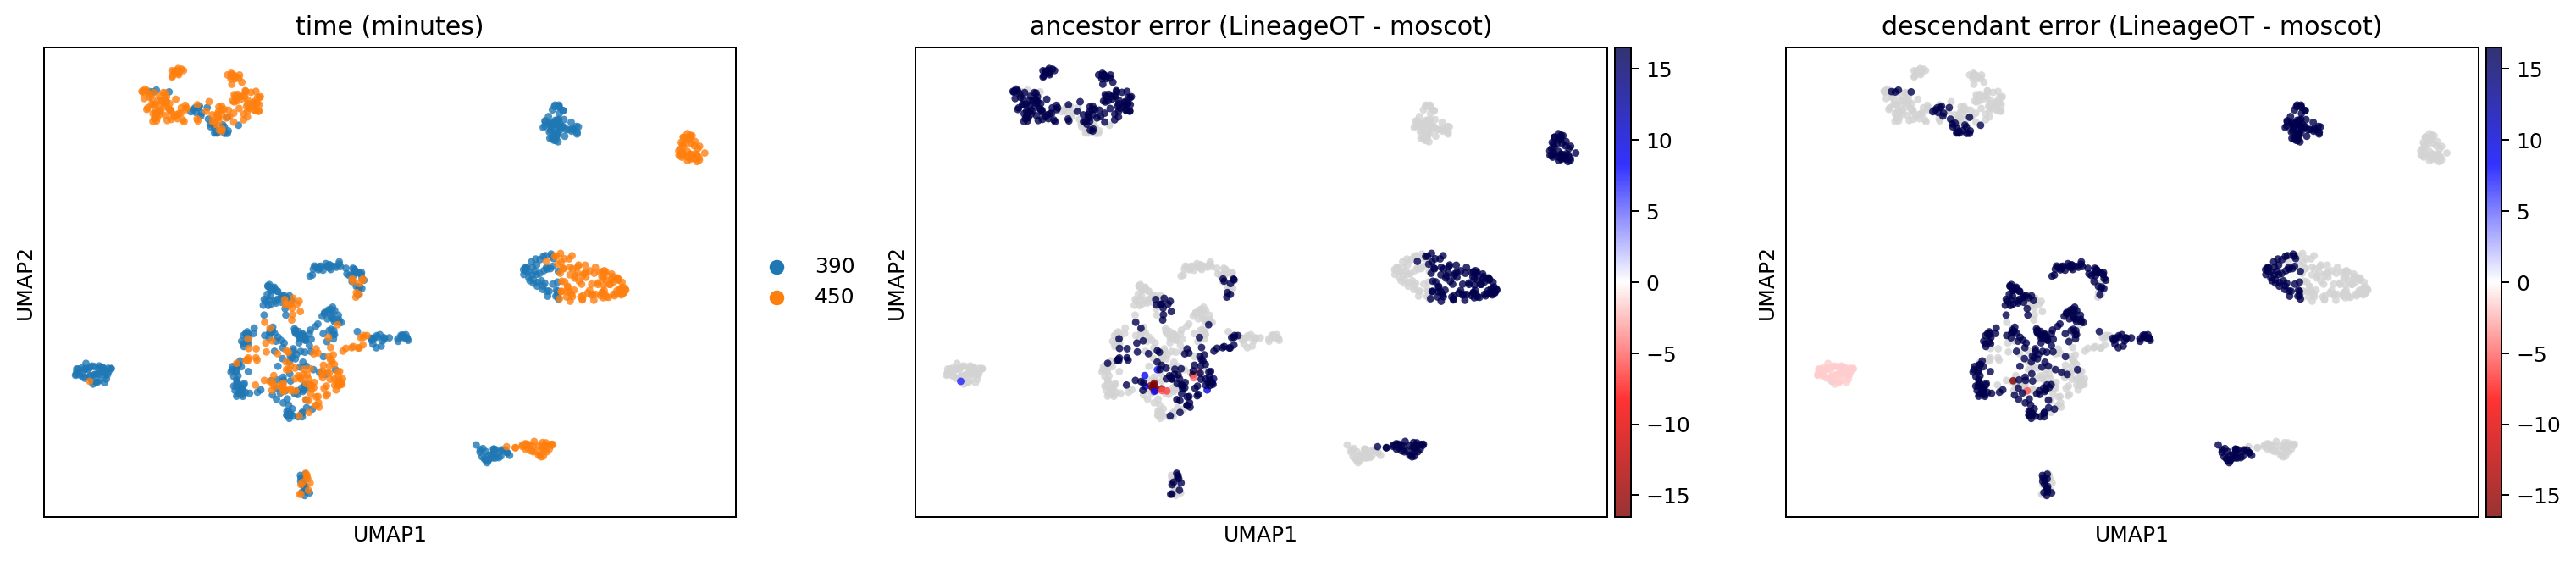

In [27]:
plot(adata, 170, 210, moscot_key=None, lot_key=None)
plot(adata, 390, 450, moscot_key=None, lot_key=None)